# Visualizations from preloaded sample Synthea dataset from AWS and queried with Athena

In [1]:
import awswrangler as wr
import pandas as pd
import matplotlib.pyplot as plt
import os

viz_dir = os.path.join("..", "visualizations")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.grid"] = True

### Set database name and paste queries

In [2]:
database = "fhir_datastore"

queries = {
    "Average_LOS_per_Encounter": """
WITH los_per_encounter AS (
  SELECT 
    e."class"."code" AS encounter_type,
    date_diff(
      'hour',
      from_iso8601_timestamp(e.period."start"),
      from_iso8601_timestamp(e.period."end")
    ) AS los_hours
  FROM "fhir_datastore"."encounter" AS e
  WHERE e.period."start" IS NOT NULL
    AND e.period."end" IS NOT NULL
)
SELECT 
  encounter_type,
  COUNT(*) AS encounter_count,
  ROUND(AVG(los_hours), 2) AS avg_los_hours
FROM los_per_encounter
GROUP BY encounter_type
ORDER BY avg_los_hours DESC;
""",
    "Patient_Comorbidity_by_Age": """
WITH condition_counts AS (
  SELECT
    replace(c.subject.reference, 'Patient/', '') AS patient_id,
    COUNT(DISTINCT c.code.text) AS num_conditions
  FROM fhir_datastore.condition c
  WHERE c.subject.reference IS NOT NULL
  GROUP BY replace(c.subject.reference, 'Patient/', '')
),
patient_ages AS (
  SELECT
    p.id AS patient_id,
    date_diff(
      'year',
      date_parse(p.birthdate, '%Y-%m-%d'),
      current_date
    ) AS age
  FROM fhir_datastore.patient p
  WHERE p.birthdate IS NOT NULL
),
merged AS (
  SELECT
    cc.patient_id,
    cc.num_conditions,
    CASE
      WHEN pa.age < 18 THEN '0–17'
      WHEN pa.age BETWEEN 18 AND 35 THEN '18–35'
      WHEN pa.age BETWEEN 36 AND 55 THEN '36–55'
      WHEN pa.age BETWEEN 56 AND 75 THEN '56–75'
      ELSE '76+'
    END AS age_group,
    CASE
      WHEN cc.num_conditions BETWEEN 0 AND 2 THEN '0–2'
      WHEN cc.num_conditions BETWEEN 3 AND 5 THEN '3–5'
      WHEN cc.num_conditions BETWEEN 6 AND 8 THEN '6–8'
      ELSE '9+'
    END AS condition_bracket
  FROM condition_counts cc
  JOIN patient_ages pa
    ON cc.patient_id = pa.patient_id
)
SELECT
  age_group,
  condition_bracket,
  COUNT(*) AS patient_count,
  ROUND(AVG(num_conditions), 2) AS avg_num_conditions
FROM merged
GROUP BY age_group, condition_bracket
ORDER BY age_group, condition_bracket;
""",
    "Demographics_by_Gender_Age": """
WITH ages AS (
  SELECT
    id,
    gender,
    date_diff(
      'year',
      date_parse(birthdate, '%Y-%m-%d'),
      current_date
    ) AS age
  FROM fhir_datastore.patient
),
brackets AS (
  SELECT
    id,
    gender,
    CASE
      WHEN age < 18 THEN '0–17'
      WHEN age BETWEEN 18 AND 35 THEN '18–35'
      WHEN age BETWEEN 36 AND 55 THEN '36–55'
      WHEN age BETWEEN 56 AND 75 THEN '56–75'
      ELSE '76+'
    END AS age_bracket
  FROM ages
)
SELECT
  gender,
  age_bracket,
  COUNT(*) AS patient_count
FROM brackets
GROUP BY gender, age_bracket
ORDER BY age_bracket, gender;
""",
    "Top10_Vaccines": """
SELECT
  vaccinecode.text AS vaccine_type,
  COUNT(*) AS total_administered
FROM fhir_datastore.immunization
GROUP BY vaccinecode.text
ORDER BY total_administered DESC
LIMIT 10;
""",
    "High_Utilizer_Cohort": """
SELECT
  subject.reference AS patient_id,
  COUNT(*) AS obs_count
FROM fhir_datastore.observation
WHERE subject.reference IS NOT NULL
GROUP BY subject.reference
HAVING COUNT(*) > 50
ORDER BY obs_count DESC;
""",
    "MedRequests_by_Drug": """
SELECT
  medicationcodeableconcept.text AS drug,
  COUNT(*) AS request_count
FROM fhir_datastore.medicationrequest
GROUP BY medicationcodeableconcept.text
ORDER BY request_count DESC
LIMIT 10;
""",
    "Avg_BloodPressure_Over_Time": """
SELECT
  date_trunc(
    'month',
    CAST(from_iso8601_timestamp(effectivedatetime) AS timestamp)
  ) AS month,
  AVG(comp.valuequantity.value) AS avg_bp
FROM fhir_datastore.observation
CROSS JOIN UNNEST(component) AS t(comp)
WHERE code.text = 'Blood Pressure'
  AND comp.valuequantity.value IS NOT NULL
GROUP BY 1
ORDER BY 1;
""",
    "Top10_Diagnoses": """
SELECT
  code.text AS condition,
  COUNT(*) AS occurrences
FROM fhir_datastore.condition
WHERE code.text IS NOT NULL
GROUP BY code.text
ORDER BY occurrences DESC
LIMIT 10;
""",
    "Encounter_Volume_by_Day": """
SELECT
  day_of_week,
  COUNT(*) AS encounters
FROM (
  SELECT
    date_format(
      cast(from_iso8601_timestamp(period.start) AS timestamp),
      '%W'
    ) AS day_of_week
  FROM fhir_datastore.encounter
  WHERE period.start IS NOT NULL
)
GROUP BY day_of_week
ORDER BY
  CASE day_of_week
    WHEN 'Sunday' THEN 1
    WHEN 'Monday' THEN 2
    WHEN 'Tuesday' THEN 3
    WHEN 'Wednesday' THEN 4
    WHEN 'Thursday' THEN 5
    WHEN 'Friday' THEN 6
    WHEN 'Saturday' THEN 7
    ELSE 8
  END;
""",
    "Repeat_Visits": """
SELECT
  subject.reference AS patient_id,
  COUNT(*) AS num_visits,
  MIN(from_iso8601_timestamp(period.start)) AS first_visit,
  MAX(from_iso8601_timestamp(period.start)) AS last_visit
FROM fhir_datastore.encounter
WHERE period.start IS NOT NULL
GROUP BY subject.reference
HAVING COUNT(*) > 1;
"""
}


## Patient Comorbidity Burden by Age Group

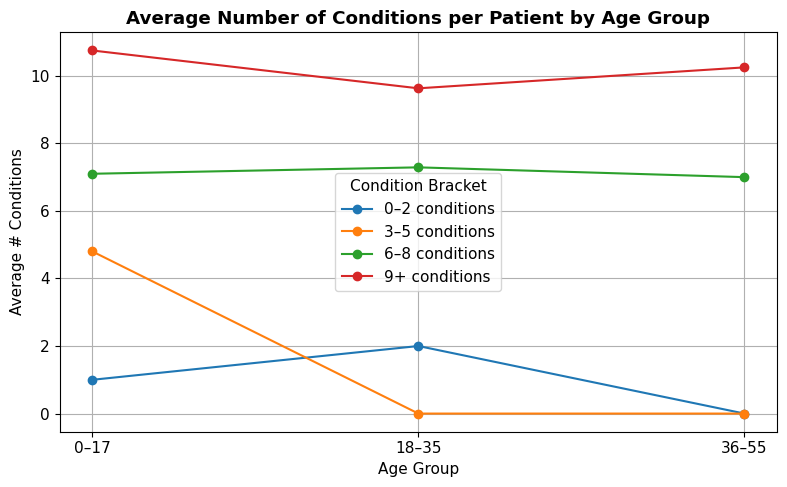

In [3]:
df_com = wr.athena.read_sql_query(sql=queries["Patient_Comorbidity_by_Age"], database=database)

pivot_com = df_com.pivot(index="age_group", columns="condition_bracket", values="avg_num_conditions").fillna(0)
fig, ax = plt.subplots()
for bracket in pivot_com.columns:
    ax.plot(pivot_com.index, pivot_com[bracket], marker="o", label=f"{bracket} conditions")
ax.set_title("Average Number of Conditions per Patient by Age Group")
ax.set_xlabel("Age Group")
ax.set_ylabel("Average # Conditions")
ax.legend(title="Condition Bracket")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
fig_path = os.path.join(viz_dir, "patient_comorbidity_burden_by_age_group.png")
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

## Patient Demographics by Gender & Age Bracket

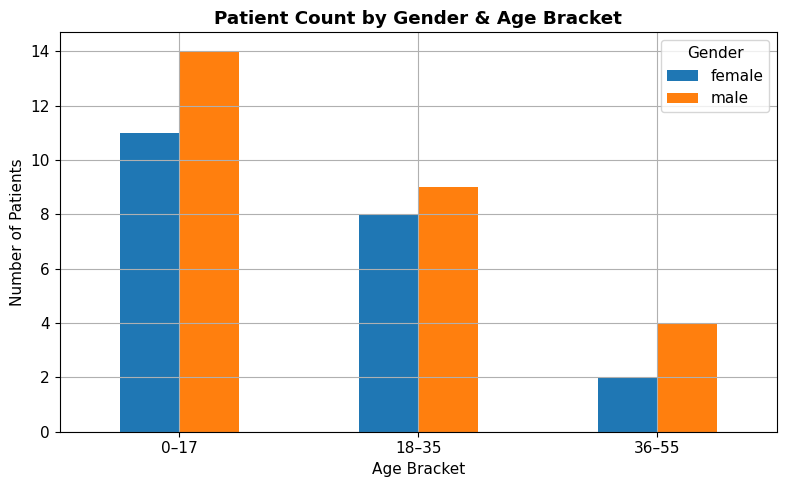

In [4]:
df_demo = wr.athena.read_sql_query(sql=queries["Demographics_by_Gender_Age"], database=database)

pivot_demo = df_demo.pivot(index="age_bracket", columns="gender", values="patient_count")

fig, ax = plt.subplots()
pivot_demo.plot(kind="bar", ax=ax)
ax.set_title("Patient Count by Gender & Age Bracket")
ax.set_xlabel("Age Bracket")
ax.set_ylabel("Number of Patients")
ax.legend(title="Gender")
ax.tick_params(axis="x", rotation=0)
plt.tight_layout()
plt.show()
fig_path = os.path.join(viz_dir, "patient_demographics_by_gender_age.png")
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

## High-Utilizer Cohort: Patients with >50 Observations (top 10)

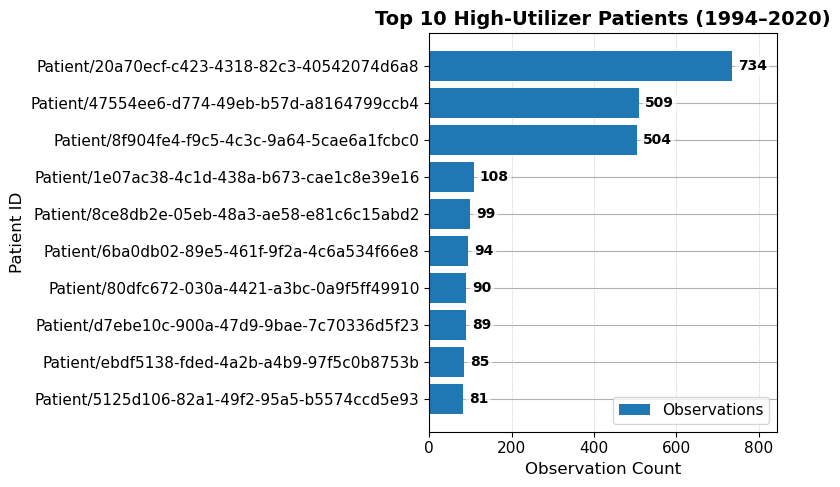

In [5]:
df_high = wr.athena.read_sql_query(
    sql=queries["High_Utilizer_Cohort"],
    database=database,
    ctas_approach=False
)
df_top10 = df_high.nlargest(10, "obs_count")

fig, ax = plt.subplots(figsize=(8, 5))

ax.barh(df_top10["patient_id"], df_top10["obs_count"], label="Observations", zorder=2)
ax.invert_yaxis()

ax.grid(axis="x", linestyle=":", linewidth=0.5, zorder=1)

xmax = df_top10["obs_count"].max()
ax.set_xlim(right=xmax * 1.15)

ax.set_title("Top 10 High-Utilizer Patients (1994–2020)", fontsize=14, fontweight="bold")
ax.set_xlabel("Observation Count", fontsize=12)
ax.set_ylabel("Patient ID", fontsize=12)
ax.legend()

for i, (pid, cnt) in enumerate(zip(df_top10["patient_id"], df_top10["obs_count"])):
    ax.text(
        cnt + xmax * 0.02,
        i,
        str(cnt),
        va="center", ha="left",
        fontsize=10, fontweight="bold",
        zorder=5,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, edgecolor="none"),
        clip_on=False
    )

plt.tight_layout()
plt.show()
fig_path = os.path.join(viz_dir, "patients_over_50_obs.png")
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

## Medication Requests by Drug Name

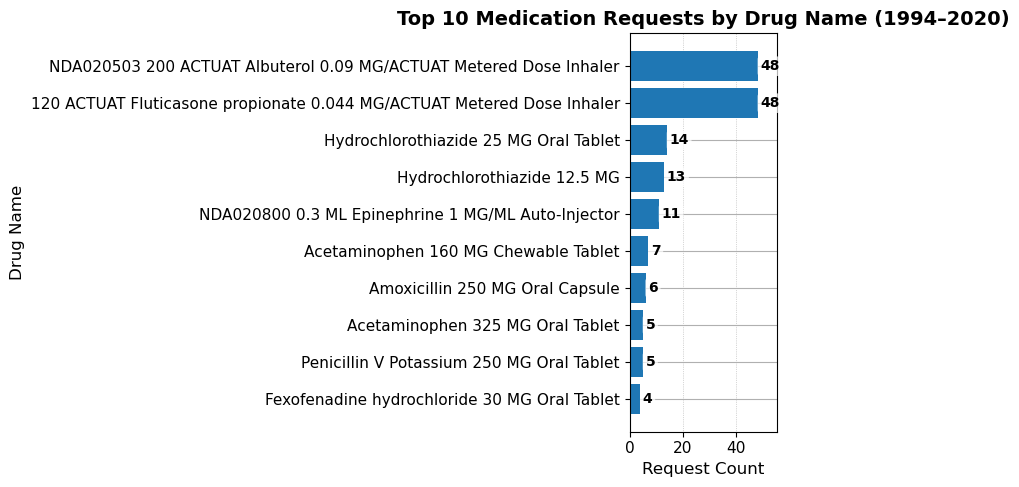

In [6]:
df_med = wr.athena.read_sql_query(
    sql=queries["MedRequests_by_Drug"],
    database=database,
    ctas_approach=False
)

fig, ax = plt.subplots(figsize=(8, 5))

ax.barh(
    df_med["drug"],
    df_med["request_count"],
    label="Requests",
    zorder=2
)
ax.invert_yaxis()

ax.grid(axis="x", linestyle=":", linewidth=0.5, zorder=1)

xmax = df_med["request_count"].max()
ax.set_xlim(right=xmax * 1.15)

ax.set_title("Top 10 Medication Requests by Drug Name (1994–2020)", fontsize=14, fontweight="bold")
ax.set_xlabel("Request Count", fontsize=12)
ax.set_ylabel("Drug Name", fontsize=12)

for i, val in enumerate(df_med["request_count"]):
    ax.text(
        val + xmax * 0.02,
        i, 
        str(val), 
        va="center", ha="left",
        fontsize=10, fontweight="bold",
        zorder=5,   
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, edgecolor="none"),
        clip_on=False
    )

plt.tight_layout()
plt.show()
fig_path = os.path.join(viz_dir, "top_10_medication_reqs.png")
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

## Top 10 Diagnoses by Frequency (1994-2020)

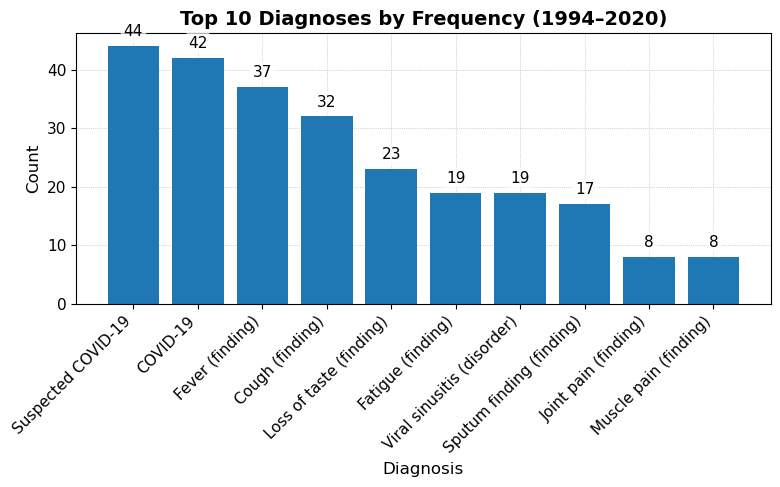

In [7]:
df_diag = wr.athena.read_sql_query(
    sql=queries["Top10_Diagnoses"],
    database=database,
    ctas_approach=False
)


df_diag["label"] = (
    df_diag["condition"]
      .astype(str)
      .str.extract(r"display=([^,\}\]]+)", expand=False)
      .fillna(df_diag["condition"].astype(str))
)

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(df_diag["label"], df_diag["occurrences"], zorder=2)
ax.grid(True, linestyle=":", linewidth=0.5, zorder=1)

for idx, cnt in enumerate(df_diag["occurrences"]):
    ax.annotate(
        str(cnt),
        xy=(idx, cnt),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom",
        zorder=5,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, edgecolor="none"),
        clip_on=False
    )

ax.set_title("Top 10 Diagnoses by Frequency (1994–2020)", fontsize=14, fontweight="bold")
ax.set_xlabel("Diagnosis", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
fig_path = os.path.join(viz_dir, "top_10_diagnoses_by_freq.png")
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

## Daily Encounter Volume count

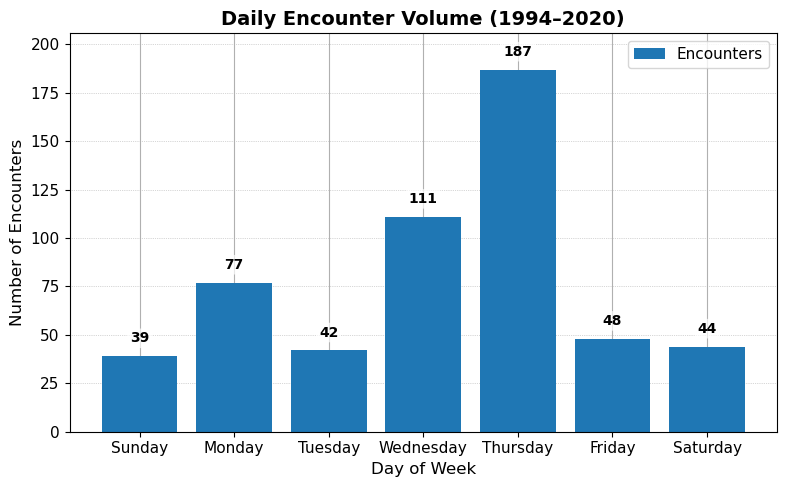

In [8]:
df_enc = wr.athena.read_sql_query(sql=queries["Encounter_Volume_by_Day"], database=database)
order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
df_enc["day_of_week"] = pd.Categorical(df_enc["day_of_week"], categories=order, ordered=True)
df_enc = df_enc.sort_values("day_of_week")

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(df_enc["day_of_week"], df_enc["encounters"], zorder=2, label="Encounters")

ax.grid(axis="y", linestyle=":", linewidth=0.5, zorder=1)

ymax = df_enc["encounters"].max()
ax.set_ylim(top=ymax * 1.10)

ax.set_title("Daily Encounter Volume (1994–2020)", fontsize=14, fontweight="bold")
ax.set_xlabel("Day of Week", fontsize=12)
ax.set_ylabel("Number of Encounters", fontsize=12)
ax.legend()
plt.xticks(rotation=0)

for idx, val in enumerate(df_enc["encounters"]):
    ax.text(
        idx,                
        val + ymax * 0.03,   
        str(val),      
        ha="center", va="bottom",
        fontsize=10, fontweight="bold",
        zorder=5,       
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, edgecolor="none"),
        clip_on=False   
    )

plt.tight_layout()
plt.show()
fig_path = os.path.join(viz_dir, "daily_encounter_volume.png")
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

## Repeat Visits by Patient: distribution of visit counts among those with >1 visit

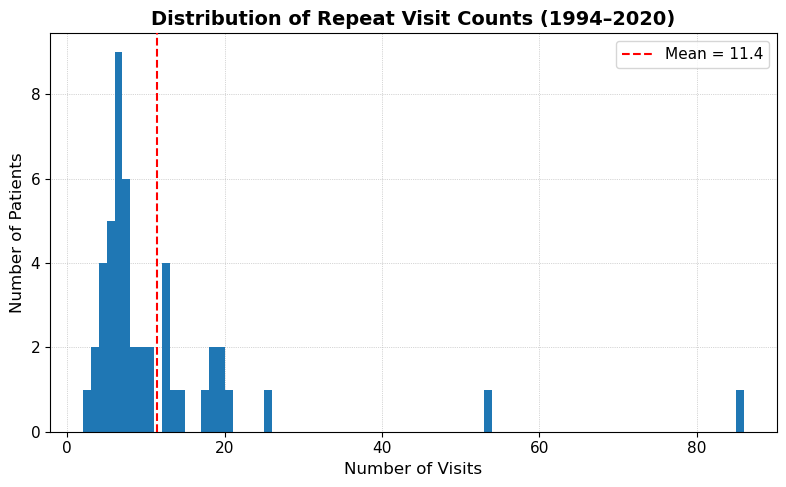

In [9]:
df_rep = wr.athena.read_sql_query(
    sql=queries["Repeat_Visits"],
    database=database,
    ctas_approach=False 
)

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df_rep["num_visits"], bins=range(2, df_rep["num_visits"].max() + 2), zorder=2)
ax.grid(True, linestyle=":", linewidth=0.5, zorder=1)

mean_visits = df_rep["num_visits"].mean()
ax.axvline(mean_visits, linestyle="--", color="red", zorder=3, label=f"Mean = {mean_visits:.1f}")
ax.legend()

ax.set_title("Distribution of Repeat Visit Counts (1994–2020)", fontsize=14, fontweight="bold")
ax.set_xlabel("Number of Visits", fontsize=12)
ax.set_ylabel("Number of Patients", fontsize=12)

plt.tight_layout()
plt.show()
fig_path = os.path.join(viz_dir, "distribution_of_repeat_visit_counts.png")
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

## Average blood pressure over time

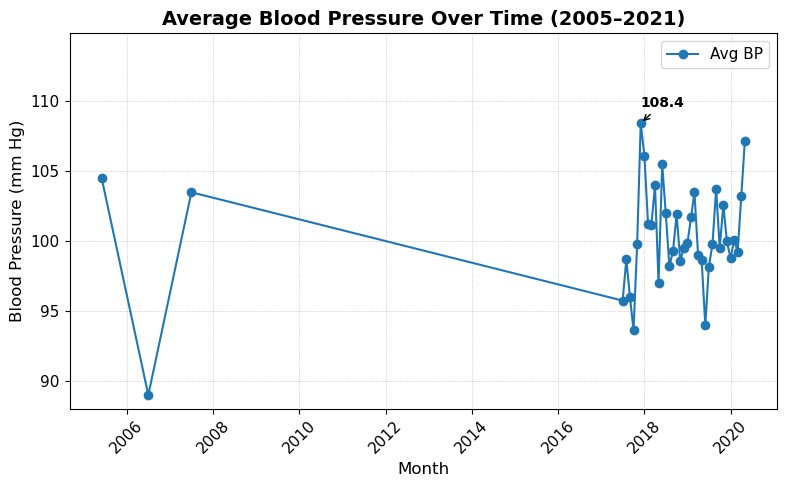

In [10]:
df_bp = wr.athena.read_sql_query(
    sql=queries["Avg_BloodPressure_Over_Time"],
    database=database,
    ctas_approach=False
)

fig, ax = plt.subplots(figsize=(8,5))


ax.plot(
    df_bp["month"], df_bp["avg_bp"],
    marker="o", linewidth=1.5, label="Avg BP",
    zorder=2
)


ax.set_title("Average Blood Pressure Over Time (2005–2021)",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Blood Pressure (mm Hg)", fontsize=12)
ax.tick_params(axis="x", rotation=45)
ax.legend()


ax.grid(True, linestyle=":", linewidth=0.5, zorder=1)


max_idx = df_bp["avg_bp"].idxmax()
x_peak = df_bp["month"].iloc[max_idx]
y_peak = df_bp["avg_bp"].iloc[max_idx]


ymax = ax.get_ylim()[1]
ax.set_ylim(top=ymax * 1.05)


ax.annotate(
    f"{y_peak:.1f}",
    xy=(x_peak, y_peak),
    xytext=(0, 12),    
    textcoords="offset points",
    fontsize=10,
    fontweight="bold",
    arrowprops=dict(arrowstyle="->", lw=1),
    zorder=5,            
    clip_on=False       
)

plt.tight_layout()
plt.show()
fig_path = os.path.join(viz_dir, "avg_bp_over_time.png")
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

## Top 10 Vaccines by # Administered

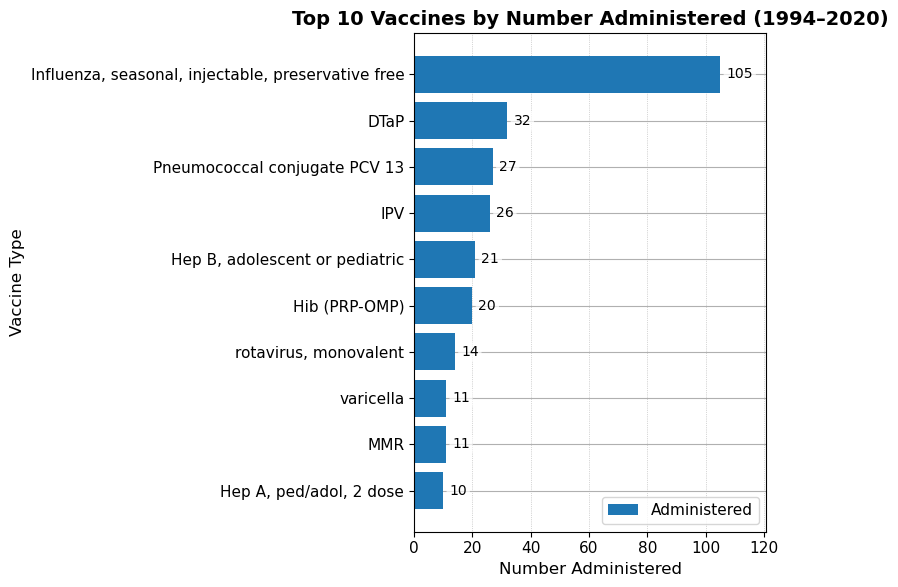

In [11]:
df_vax = wr.athena.read_sql_query(
    sql=queries["Top10_Vaccines"],
    database=database,
    ctas_approach=False
)

fig, ax = plt.subplots(figsize=(8, 6))


ax.barh(
    df_vax["vaccine_type"],
    df_vax["total_administered"],
    label="Administered",
    zorder=2
)


ax.invert_yaxis()

ax.set_title("Top 10 Vaccines by Number Administered (1994–2020)",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Number Administered", fontsize=12)
ax.set_ylabel("Vaccine Type", fontsize=12)
ax.legend()


ax.grid(axis="x", linestyle=":", linewidth=0.5, zorder=1)


xmax = df_vax["total_administered"].max()
ax.set_xlim(right=xmax * 1.15)

for i, cnt in enumerate(df_vax["total_administered"]):
    ax.text(
        cnt + xmax * 0.02, 
        i,
        str(cnt),
        va="center",
        ha="left",
        fontsize=10,
        zorder=5,   
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, edgecolor="none"),
        clip_on=False  
    )

plt.tight_layout()
plt.show()
fig_path = os.path.join(viz_dir, "top_10_vaccines_administered.png")
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

## Average Length of Stay by Encounter

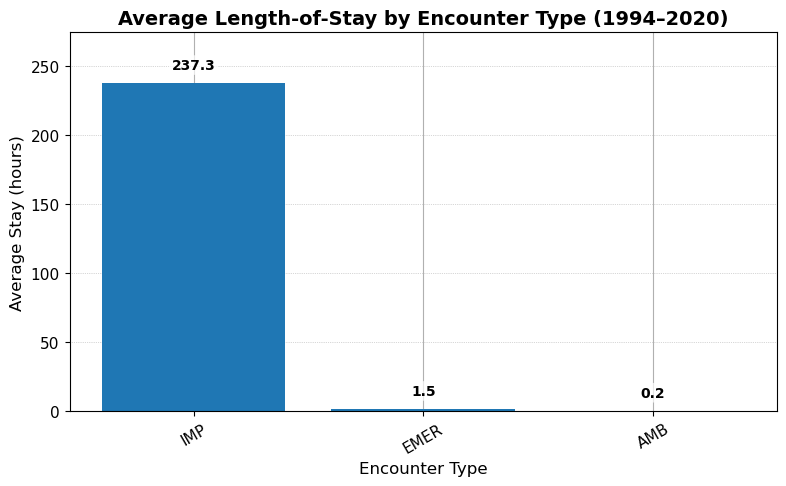

In [12]:
df_los = wr.athena.read_sql_query(
    sql=queries["Average_LOS_per_Encounter"],
    database=database,
    ctas_approach=False
)


fig, ax = plt.subplots(figsize=(8, 5))


ax.bar(
    df_los["encounter_type"],
    df_los["avg_los_hours"],
    zorder=2
) 

ax.grid(
    axis="y",
    linestyle=":",
    linewidth=0.5,
    zorder=1
)  


ax.set_title("Average Length-of-Stay by Encounter Type (1994–2020)",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Encounter Type", fontsize=12)
ax.set_ylabel("Average Stay (hours)", fontsize=12) 
ax.tick_params(axis="x", rotation=30)

ymax = ax.get_ylim()[1]
ax.set_ylim(top=ymax * 1.10) 


for idx, val in enumerate(df_los["avg_los_hours"]):
    ax.annotate(
        f"{val:.1f}",
        xy=(idx, val),
        xytext=(0, 8),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        zorder=5,  
        bbox=dict(
            boxstyle="round,pad=0.2",
            fc="white",
            alpha=0.7,
            edgecolor="none"
        ),  
        clip_on=False 
    )

plt.tight_layout()  
plt.show()
fig_path = os.path.join(viz_dir, "avg_los_by_type.png")
fig.savefig(fig_path, dpi=300, bbox_inches='tight')

## Save tables as csv and create .sql files 

In [13]:
for name, sql in queries.items():
    print(f"Running query '{name}'…")
    df = wr.athena.read_sql_query(sql=sql, database=database, ctas_approach=False)
    path = os.path.join("csv_outputs", f"{name}.csv")
    df.to_csv(path, index=False)

Running query 'Average_LOS_per_Encounter'…
Running query 'Patient_Comorbidity_by_Age'…
Running query 'Demographics_by_Gender_Age'…
Running query 'Top10_Vaccines'…
Running query 'High_Utilizer_Cohort'…
Running query 'MedRequests_by_Drug'…
Running query 'Avg_BloodPressure_Over_Time'…
Running query 'Top10_Diagnoses'…
Running query 'Encounter_Volume_by_Day'…
Running query 'Repeat_Visits'…


In [14]:
out_dir = os.path.join("..", "athena_queries")
for name, sql in queries.items():
    safe_name = name.replace(" ", "_").replace("/", "_")
    file_path = os.path.join(out_dir, f"{safe_name}.sql")
    with open(file_path, "w") as f:
        f.write(sql.strip() + "\n")
    print(f"Saved → {file_path}")


Saved → ..\athena_queries\Average_LOS_per_Encounter.sql
Saved → ..\athena_queries\Patient_Comorbidity_by_Age.sql
Saved → ..\athena_queries\Demographics_by_Gender_Age.sql
Saved → ..\athena_queries\Top10_Vaccines.sql
Saved → ..\athena_queries\High_Utilizer_Cohort.sql
Saved → ..\athena_queries\MedRequests_by_Drug.sql
Saved → ..\athena_queries\Avg_BloodPressure_Over_Time.sql
Saved → ..\athena_queries\Top10_Diagnoses.sql
Saved → ..\athena_queries\Encounter_Volume_by_Day.sql
Saved → ..\athena_queries\Repeat_Visits.sql
